In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import namedtuple

import seaborn as sns

In [3]:
### General Processing

In [4]:
main = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'KM Data Edits')
datapull = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Data Pull Sheet')
aums = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'All Institution AUMs')
removed = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Removed cases')

In [7]:
#remove N/A data in Excel

main = main[:-6]

In [11]:
removed_tickers = pd.read_csv("excluded.csv").Ticker

In [12]:
movant_categories = main["Movant ID"].str.split(".", n=2, expand = True)
main['Movant Group'] = movant_categories[0]+movant_categories[1]

In [13]:
main = main.merge(aums[['Institutional Movant', 'AUM']], how = 'left', left_on = 'Movant', right_on = 'Institutional Movant')

In [14]:
main = main.merge(datapull[['Ticker','Damage Bucket', "Filing Firm", "Lead Plaintiff"]], how = 'left', on = 'Ticker')

In [15]:
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("InS", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ins", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("G-mix", "G-Mix")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ind", "Ind")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("g-Ind", "G-Ind")

In [16]:
main["Small Case"] = 0
main.loc[main["Damage Bucket"].isin(["A","B"]), "Small Case"] = 1 
main.loc[main["Lead Plaintiff"].isna(),"Lead Plaintiff"] = "None"

In [17]:
def win(a, b):
    if a in b: return 1
    else: return 0

main = main.assign(win = main.apply(lambda row: win(row["Movant"], row["Lead Plaintiff"]), axis =1))

In [18]:
main["unopposed"] = 0
main.loc[main["Contested/\nUncontested"]=="Uncontested", "unopposed"] = 1

In [19]:
#main["AUM"] = main.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)
#main["Movant Loss"] = main.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#datapull["Total Damages"] = datapull.apply(lambda x: '${:,.2f}'.format(x["Total Damages"]), axis = 1)

### I. MOVANT ANALYSIS BY REPORTED DAMAGES BY BUCKET

#### I. A. Number of Cases by Bucket

In [20]:
data_1 = datapull[datapull["Damage Bucket"] != "DC"]

In [21]:
data_1a = data_1['Damage Bucket'].value_counts()

In [22]:
y_val = data_1a.sort_index()
x_val = data_1a.sort_index().index

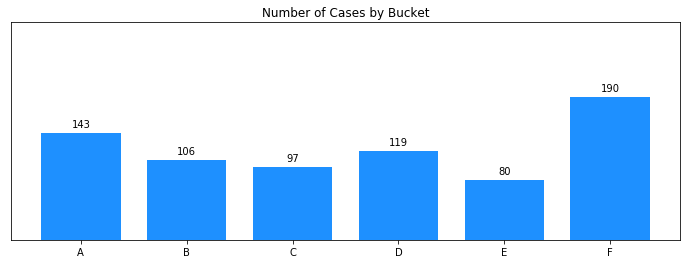

In [23]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Cases by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

ax.set_ylim([0,y_val.max()+ 100])

rects = ax.patches

ax.yaxis.set_ticks_position('none')

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### I.B. Analysis by Bucket

In [24]:
data_1b = data_1[['Damage Bucket', 'Ticker','Total Damages', '% of Total Damages']].dropna()
data_1b['Total Damages'] = pd.to_numeric(data_1b['Total Damages'], errors='coerce').fillna(0)
data_1b['% of Total Damages'] = pd.to_numeric(data_1b['% of Total Damages'], errors='coerce').fillna(0)
data_1b = data_1b[~data_1b.Ticker.isin(data_1b[(data_1b['Damage Bucket']=='DC')]['Ticker'])]


In [25]:
data_1b_total = data_1b[['Damage Bucket', 'Ticker','Total Damages']]
data_1b_describe_total = data_1b_total.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = 'Total Damages')
data_1b_describe_total = data_1b_describe_total.describe()

In [26]:
data_1b_bps = data_1b[['Damage Bucket', 'Ticker','% of Total Damages']]
data_1b_describe_bps = data_1b_bps.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = '% of Total Damages')
data_1b_describe_bps = data_1b_describe_bps.describe()

In [27]:
x_val = np.sort(data_1b['Damage Bucket'].unique())

In [ ]:
#### plt.clf()
pd.options.display.float_format = '${:,.0f}'.format
plt.figure(figsize=(12,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[~data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[:4], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [ ]:
plt.figure(figsize=(5,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[data_1b_total["Damage Bucket"].isin(["DC", "E", "F"])], order = x_val[4:7], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [ ]:
print("By Total Damage")
data_1b_describe_total

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
print("By BPS, Does Not Include DC Damages in Bucket F")
data_1b_describe_bps 

#### Largest and 2nd Largest Bucket

In [ ]:
for i in x_val:
    data_1b_largest = np.sort(main[(main["Damage Bucket"] == i) & (~main["Ticker"].isin(removed_tickers))].pivot_table(index = "Movant ID", columns = "Ticker", values = "Total Damages in Group").fillna(0), axis = 0)[-2:,:]
    if i == "A":
        data_1b_largest1 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()
        data_1b_largest2 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()
    else:
        data_1b_largest1 = pd.concat([data_1b_largest1, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()], axis = 1)       
        data_1b_largest2 = pd.concat([data_1b_largest2, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()], axis = 1)

In [ ]:
data_1b_largest1.columns = x_val.tolist()
data_1b_largest2.columns = x_val.tolist()

In [ ]:
pd.options.display.float_format = '${:,.0f}'.format
print("Largest Movants")
data_1b_largest1

In [ ]:
pd.options.display.float_format = '${:,.0f}'.format
print("Second Largest Movants")
data_1b_largest2

#### I.C. Win-Loss Analysis

In [ ]:
data_1c = main[main["Damage Bucket"] != "DC"][["Movant", "Damage Bucket", "Type", "win", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]]

#### I.C.1 Largest Movant

In [ ]:
data_1c1_wins = main.groupby("Movant")["win"].agg(["sum", "count"])
data_1c1_wins["win_rate"] = data_1c1_wins["sum"]/data_1c1_wins["count"]
data_1c1_losses_inst = main[main.Type == "Institution"].groupby("Movant")["Movant Loss"].sum()
data_1c1_losses_ind = main[main.Type == "Individual"].groupby("Movant")["Movant Loss"].sum()
data_1c1_largest_inst = data_1c1_losses_inst[data_1c1_losses_inst == data_1c1_losses_inst.max()].index
data_1c1_largest_ind = data_1c1_losses_ind[data_1c1_losses_ind == data_1c1_losses_ind.max()].index

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest institutional movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest_inst)]

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest individual movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest_ind)]

In [ ]:
#### I.C.2 Win Rate by Movant Category

In [ ]:
data_1c2 = data_1c.groupby("Type")["win"].agg(["sum", "count"])
data_1c2["win_rate"] = data_1c2["sum"]/data_1c2["count"]

In [ ]:
x_val = data_1c2.index
y_val = data_1c2.win_rate

fig, ax = plt.subplots(figsize=(6,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category (All Movants)')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [ ]:
#### I.C.3. Win Rate By Bucket

In [ ]:
data_1c3 = data_1c.groupby("Damage Bucket")["win"].agg(["sum", "count"])
data_1c3["win_rate"] = data_1c3["sum"]/data_1c3["count"]

In [ ]:
x_val = data_1c3.index
y_val = data_1c3.win_rate

In [ ]:

fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Damage Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [ ]:
#### I.C.4. Win Rate By Bucket by Movant Type

In [ ]:
data_1c4 = data_1c.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Damage Bucket"])["win"].agg(["sum", "count"])
data_1c4["win_rate"] = data_1c4["sum"]/data_1c4["count"]

In [ ]:
x_val = data_1c4.index
y_val = data_1c4.win_rate

In [ ]:
x_val

In [ ]:
y_val["G-Ind"]

In [ ]:
y_val

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
width = 0.15
ind = np.arange(6)
legends = ["G-Ind", "G-Ins", "G-Mix", "Ind", "Ins"]
buckets = ["A", "B", "C", "D", "E", "F"]
colors=['teal', 'gold', 'plum', 'darkseagreen', 'lightcoral', "mediumorchid"]

plt.title('Win Rate by Type and Bucket')
plt.yticks([], [])

rects = []

for i in range(len(legends)):
    box = ax.bar(ind + width*(i-1), y_val[legends[i]], width, color = colors[i], label = legends[i])
    rects.append(box)

plt.legend([i for i in rects], legends)


ax.set_xticks(ind+width)
ax.set_xticklabels(buckets)
ax.yaxis.set_ticks_position('none')
ax.set_ylim([0,y_val.max()+ 0.1])

def autolabel(i):
    for rect in i:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, "{:,.0%}".format(h),
                ha='center', va='bottom')
        
for i in rects:
    autolabel(i)



plt.show()

### II. ANALYSIS BY TYPE OF MOVANT

#### II. A. Number of Movants by Bucket

In [ ]:
data_2 = main[main["Damage Bucket"] != "DC"]

In [ ]:
data_2a = data_2["Damage Bucket"].value_counts()

In [ ]:
y_val = data_2a.sort_index()
x_val = data_2a.sort_index().index

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### II.B. Number of Movants by Case

In [ ]:
data_2b = data_2.groupby("Ticker")["Movant ID"].count().reset_index()
data_2b_describe = data_2b.describe()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
data_2b_describe

#### II.C. Movant By Type By Bucket

In [ ]:
data_2c = data_2[["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant ID"]]

In [ ]:
data_2c_grouped = data_2c.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].count().reset_index()

In [ ]:
data_2c_grouped

#### II.D. For Groups

In [ ]:
data_2d_type = data_2[["Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_type_groupcount = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant ID"].nunique()/data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_type_groupcount = data_2d_type_groupcount.append(pd.Series(data_2d_type["Movant ID"].nunique()/data_2d_type["Movant Group"].nunique(), index = ["Total"]))
data_2d_type_loss = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Loss"].mean()
data_2d_type_loss = data_2d_type_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_type_winrate = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].sum()/data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()
data_2d_type_winrate = data_2d_type_winrate.append(pd.Series(main["win"].sum()/main["win"].count(), index = ["Total"]))

data_2d_type = pd.concat([data_2d_type_groupcount, data_2d_type_loss, data_2d_type_winrate], axis = 1)
data_2d_type.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d_type["Avg Losses"] = data_2d_type.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)
data_2d_type["Win Rate"] = data_2d_type.apply(lambda x: "{:,.1%}".format(x["Win Rate"]), axis = 1)

print("Statistics by Type")
pd.options.display.float_format = '{:,.2f}'.format
data_2d_type

In [ ]:
data_2d_type_bucket = data_2[["Damage Bucket", "Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_type_bucket_groupcount = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].nunique()/data_2d_type_bucket.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_type_bucket_groupcount = data_2d_type_bucket_groupcount.append(pd.Series(data_2d_type_bucket["Movant ID"].nunique()/data_2d_type_bucket["Movant Group"].nunique(), index = ["Total"]))
data_2d_type_bucket_loss = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant Loss"].mean()
data_2d_type_bucket_loss = data_2d_type_bucket_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_type_bucket_winrate = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["win"].sum()/data_2d_type_bucket.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()
data_2d_type_bucket_winrate = data_2d_type_bucket_winrate.append(pd.Series(main["win"].sum()/main["win"].count(), index = ["Total"]))

data_2d_type_bucket = pd.concat([data_2d_type_bucket_groupcount, data_2d_type_bucket_loss, data_2d_type_bucket_winrate], axis = 1)
data_2d_type_bucket.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d_type_bucket["Avg Losses"] = data_2d_type_bucket.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)
data_2d_type_bucket["Win Rate"] = data_2d_type_bucket.apply(lambda x: "{:,.1%}".format(x["Win Rate"]), axis = 1)

print("Statistics by type_bucket")
pd.options.display.float_format = '{:,.2f}'.format
data_2d_type_bucket

#### II.E. For Unopposed Lead Plaintiff Motions

In [ ]:
data_2e = data_2[data_2["unopposed"]==1][["Damage Bucket","Movant","Movant Loss"]]

#### III.E.1. Number of Unopposed by Bucket

In [ ]:
data_2e1 = data_2e.groupby("Damage Bucket")["Movant"].count().reset_index()

In [ ]:
data_2e1

#### II.E.2 Average Loss of Unopposed by Bucket

In [ ]:
data_2e2 = data_2e.groupby("Damage Bucket")["Movant Loss"].mean().reset_index()
data_2e2["Movant Loss"] = data_2e2.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)


In [ ]:
pd.options.display.float_format = '${:,.2}'.format
data_2e2

#### II.F. Fight Analysis

In [ ]:
data_2f = main[["Small Case", "Type", "win"]]

In [ ]:
data2f_wins = data_2f.groupby(["Small Case", "Type"])["win"].agg(["sum", "count"])
data2f_wins["win_rate"] = data2f_wins["sum"]/  data2f_wins["count"]

In [ ]:
pd.options.display.float_format = '{:.1%}'.format
data2f_wins["win_rate"].reset_index()

### III. ANALYSIS BY INSTITUTIONAL MOVEMENT TYPE

#### III. A. Institutional Movants by Bucket

In [ ]:
data_3 = main[(main["Type"]== "Institution") & (main["Damage Bucket"] != "DC")]

In [ ]:
data_3a = data_3.groupby('Damage Bucket')['Institutional Movant'].count()

In [ ]:
y_val = data_3a.sort_index()
x_val = data_3a.sort_index().index

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Institutional Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### III.B Average Loss By Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [ ]:
data_3b = data_3[['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3b_describe = data_3b.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b_describe = data_3b_describe.describe()

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
print("Duplicate institutional movants")
data_3b_describe

In [ ]:
print("Unique institutional movants")
data_3b1 = data_3[['Damage Bucket', "Movant", "Type", 'Movant Loss']].dropna()
data_3b1 = data_3b1.groupby(["Movant","Type","Damage Bucket"])["Movant Loss"].sum().reset_index()
data_3b1 = data_3b1.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b1_describe = data_3b1.describe()

In [ ]:
data_3b1_describe

#### III.C. Average Loss By Winning Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [ ]:
data_3c = data_3[data_3.win==1][['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3c_describe = data_3c.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3c_describe = data_3c_describe.describe()

In [ ]:
data_3c_describe

#### III.D. Average AUM of Institutional Movant by Bucket
##### Note: Count Includes Only Institutional Movants with AUMs (no N/As)

In [ ]:
data_3d = main[['Damage Bucket',  "Institutional Movant", "AUM"]].dropna()
data_3d_describe = data_3d.pivot(columns = 'Damage Bucket', values = 'AUM')
data_3d_describe = data_3d_describe.describe()

In [ ]:
pd.options.display.float_format = '${:,.0f}'.format
data_3d_describe

#### III.E. Frequent Flyer Analysis

#### III.E.1. Movant Type

In [ ]:
data_3e = main[["Institutional Movant", "Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", 'Investor Frequent Flyer', 'Movant Loss', "Filing Firm"]]
data_3e = data_3e[~data_3e["Institutional Movant"].isna()]
data_3e.loc[(data_3e["Investor Frequent Flyer"].isna()),"Investor Frequent Flyer"] = "NotFF"

In [ ]:
data_3e1 = data_3e.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")

In [ ]:
y_val1 = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Institutional Movant"]
y_val2 = data_3e1[data_3e1["Investor Frequent Flyer"]== "NotFF"]["Institutional Movant"]
x_val = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]

In [ ]:
data_3e1

#### III.E.2.By Bucket

In [ ]:
data_3e2 = data_3e.groupby(["Damage Bucket", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Damage Bucket")

In [ ]:
data_3e2

#### III.E.3.By Filing Firm

#### See attached csv

In [ ]:
#data_3e3 = main[["Movant", "Institutional Movant", "Company Name","Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Type", 'Investor Frequent Flyer', 'Movant Loss', "Firm Names - Movant", "AUM"]]
#data_3e3.loc[(data_3e3["Investor Frequent Flyer"].isna()) & (data_3e3["Type"]=="Institution"),"Investor Frequent Flyer"] = "NotFF"

In [ ]:
#data_3e3_count = data_3e3.groupby("Movant")["Type"].count().reset_index().rename(columns = {"Type": "case_count"})

In [ ]:
#data_3e3 = data_3e3.merge(data_3e3_count, how = "left", on = "Movant")

In [ ]:
#data_3e3_repeat = data_3e3[data_3e3.case_count > 1].sort_values(["Type","Movant", "Firm Names - Movant"])
#data_3e3_repeat["Movant Loss"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#data_3e3_repeat["AUM"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)

In [ ]:
#data_3e3_repeat_ind = data_3e3_repeat[data_3e3_repeat.Type == "Individual"][["Movant","Firm Names - Movant", "Company Name", "Movant Loss"]]
#data_3e3_repeat_ins = data_3e3_repeat[data_3e3_repeat.Type == "Institution"][["Movant","AUM","Firm Names - Movant", "Company Name", "Movant Loss"]]

In [ ]:
#with pd.ExcelWriter('FrequentFlyerAnalysis_201911.xlsx') as writer:  # doctest: +SKIP
#    data_3e3_repeat_ind.to_excel(writer, sheet_name='Individual', index = False)
#    data_3e3_repeat_ins.to_excel(writer, sheet_name='Institution', index = False)

In [ ]:
print("Analysis did not include movants under Damage Bucket DC")
main[main["Damage Bucket"]== "DC"]